# BC5

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

May 2022

https://github.com/fpontejos/bc5


## Initial Setup

### Imports

In [34]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections
import ta
import json
warnings.filterwarnings('ignore')



In [2]:
from functools import reduce

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [4]:
from matplotlib.colors import LinearSegmentedColormap


In [5]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


### Variables

In [70]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = 'imgs/'
DATA_IN_PATH = '../../source/data_updated/'
DATA_OUT_PATH = '../../data_out/'


In [71]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


### Styles

In [8]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

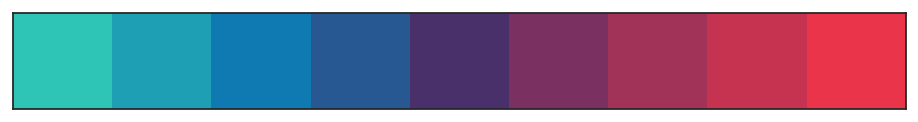

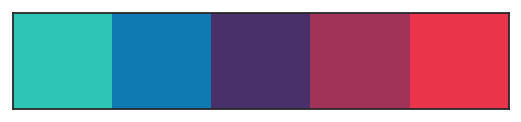

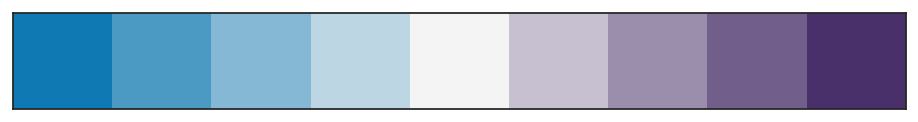

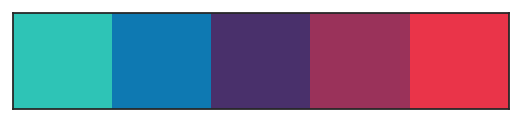

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Get Data

In [10]:
START_DATE = '2017-05-09'
END_DATE = '2022-05-08'
END_DATE_ = '2022-05-09'

In [11]:
## Gold prices as proxy for risk-aversion
stock_symbol = "VIX"
stock_data = pdr.get_data_yahoo(stock_symbol, start=START_DATE, end=END_DATE_)
stock_data = stock_data.reset_index()

[*********************100%***********************]  1 of 1 completed


### Twitter

In [12]:
import tweepy

In [13]:
## Get keys
tk = pd.read_csv('../../../twitter.csv')#.set_index('label')

apiKey = tk.loc[tk['label']=='api']['key'].values[0]
apiSecret = tk.loc[tk['label']=='apisecret']['key'].values[0]
accessToken = tk.loc[tk['label']=='accesstoken']['key'].values[0]
accessTokenSecret = tk.loc[tk['label']=='accesstokensecret']['key'].values[0]


In [14]:
# Set authentication and access token
auth = tweepy.OAuthHandler(apiKey, apiSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

noOfTweet = 1000


In [15]:
def get_tweets(sym):
    tweets = tweepy.Cursor(api.search_tweets, q=sym, tweet_mode='extended', lang='en').items(noOfTweet)
    tweet_list = []
    for t in tweets:
        if not "Bot" in t.author.name :
            tweet_list.append(t.full_text)
            
    return tweet_list

In [16]:
tweet_list = get_tweets(stock_symbol)

In [17]:
# tweet_list

In [18]:
tweet_list_ = tweet_list.copy()

In [19]:
df_tweet = pd.DataFrame(tweet_list)
df_tweet.to_csv('tweet_sample.csv', index=False)

### yfinance

In [20]:
date_interval = 365
END_DATE = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
START_DATE = (datetime.today() + timedelta(days=-date_interval)).strftime('%Y-%m-%d')

print(START_DATE, END_DATE)

2021-05-19 2022-05-20


In [21]:
def get_findata(sym, start_date, end_date):
    df_ = pdr.get_data_yahoo(sym, start=start_date, end=end_date)
    df_ = df_.reset_index().set_index('Date').asfreq('d')
    df_['DateCol'] = df_.index
    df_.fillna(method='ffill', inplace=True)    
    return df_

In [22]:
gold_data = get_findata('GC=F', START_DATE, END_DATE)

[*********************100%***********************]  1 of 1 completed


In [23]:
gold_data.head(15)

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-18,1870.500000,1870.500000,1867.800049,1867.800049,1867.800049,3.0,2021-05-18
2021-05-19,1866.400024,1884.900024,1863.599976,1881.300049,1881.300049,348.0,2021-05-19
2021-05-20,1865.500000,1885.000000,1864.800049,1881.800049,1881.800049,85.0,2021-05-20
2021-05-21,1872.099976,1876.699951,1872.099976,1876.699951,1876.699951,5.0,2021-05-21
2021-05-22,1872.099976,1876.699951,1872.099976,1876.699951,1876.699951,5.0,2021-05-22
2021-05-23,1872.099976,1876.699951,1872.099976,1876.699951,1876.699951,5.0,2021-05-23
2021-05-24,1882.099976,1884.599976,1882.099976,1884.599976,1884.599976,39.0,2021-05-24
2021-05-25,1882.500000,1898.099976,1882.500000,1898.099976,1898.099976,56.0,2021-05-25
2021-05-26,1901.300049,1901.300049,1901.300049,1901.300049,1901.300049,170526.0,2021-05-26


In [25]:
symbol = 'GOOG'
fin_data = get_findata(symbol, START_DATE, END_DATE)

[*********************100%***********************]  1 of 1 completed


In [26]:
fin_data

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-18,2336.906006,2343.149902,2303.159912,2303.429932,2303.429932,865100.0,2021-05-18
2021-05-19,2264.399902,2316.760010,2263.520020,2308.709961,2308.709961,967500.0,2021-05-19
2021-05-20,2328.040039,2360.340088,2321.090088,2356.090088,2356.090088,1191600.0,2021-05-20
2021-05-21,2365.989990,2369.000000,2342.370117,2345.100098,2345.100098,1141600.0,2021-05-21
2021-05-22,2365.989990,2369.000000,2342.370117,2345.100098,2345.100098,1141600.0,2021-05-22
...,...,...,...,...,...,...,...
2022-05-14,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-14
2022-05-15,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-15
2022-05-16,2307.679932,2332.149902,2286.699951,2295.850098,2295.850098,1164100.0,2022-05-16


In [27]:
wixinfo = yf.Ticker(symbol).info


In [28]:
#yf.Ticker('GOOGL').info
# marketcap
# industry
# sector

In [29]:
#wixinfo

In [35]:
with open('./../../data/wix.json', 'w') as fp:
    json.dump(wixinfo, fp)


In [38]:
json_object = {}
with open('./../../data/wix.json', 'r') as fp:
    json_object = json.load(fp)
#json_object


In [39]:
'longName' in json_object.keys() 

True

## Models

In [40]:
def shift_split_data(df_, target_col, fitsize=7):
    df = df_.copy()
    ## Date_Y is the date being predicted
    ## The corresponding Date_X of the same row is the previous date
    df['Date_Y'] = df['DateCol']+ pd.DateOffset(days=1) 
    df['Y'] = df[target_col].shift(periods=-1)
    df.rename(columns={'DateCol':'Date_X'}, inplace=True)
    
    ## last fitsize days to fit for prediction on the next day
    df_fit = df.iloc[-fitsize:]
    
    return df_fit
    
    

In [41]:
fin_data

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-18,2336.906006,2343.149902,2303.159912,2303.429932,2303.429932,865100.0,2021-05-18
2021-05-19,2264.399902,2316.760010,2263.520020,2308.709961,2308.709961,967500.0,2021-05-19
2021-05-20,2328.040039,2360.340088,2321.090088,2356.090088,2356.090088,1191600.0,2021-05-20
2021-05-21,2365.989990,2369.000000,2342.370117,2345.100098,2345.100098,1141600.0,2021-05-21
2021-05-22,2365.989990,2369.000000,2342.370117,2345.100098,2345.100098,1141600.0,2021-05-22
...,...,...,...,...,...,...,...
2022-05-14,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-14
2022-05-15,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-15
2022-05-16,2307.679932,2332.149902,2286.699951,2295.850098,2295.850098,1164100.0,2022-05-16


In [42]:
split_fin_data = shift_split_data(fin_data, 'Close')
split_fin_data

,Open,High,Low,Close,Adj Close,Volume,Date_X,Date_Y,Y
Date,,,,,,,,,
2022-05-12,2238.760010,2297.129883,2202.270020,2263.219971,2263.219971,2073200.0,2022-05-12,2022-05-13,2330.310059
2022-05-13,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-13,2022-05-14,2330.310059
2022-05-14,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-14,2022-05-15,2330.310059
2022-05-15,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-15,2022-05-16,2295.850098
2022-05-16,2307.679932,2332.149902,2286.699951,2295.850098,2295.850098,1164100.0,2022-05-16,2022-05-17,2334.030029
2022-05-17,2344.550049,2344.550049,2306.750000,2334.030029,2334.030029,1078800.0,2022-05-17,2022-05-18,2248.020020
2022-05-18,2304.750000,2313.913086,2242.840088,2248.020020,2248.020020,1395300.0,2022-05-18,2022-05-19,NaN


In [43]:
fin_data

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-18,2336.906006,2343.149902,2303.159912,2303.429932,2303.429932,865100.0,2021-05-18
2021-05-19,2264.399902,2316.760010,2263.520020,2308.709961,2308.709961,967500.0,2021-05-19
2021-05-20,2328.040039,2360.340088,2321.090088,2356.090088,2356.090088,1191600.0,2021-05-20
2021-05-21,2365.989990,2369.000000,2342.370117,2345.100098,2345.100098,1141600.0,2021-05-21
2021-05-22,2365.989990,2369.000000,2342.370117,2345.100098,2345.100098,1141600.0,2021-05-22
...,...,...,...,...,...,...,...
2022-05-14,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-14
2022-05-15,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-15
2022-05-16,2307.679932,2332.149902,2286.699951,2295.850098,2295.850098,1164100.0,2022-05-16


In [45]:
fin_data.to_csv('./../../data/fin_data.csv')

In [47]:
fin_data_ = pd.read_csv('./../../data/fin_data.csv')
fin_data_['Date'] = pd.to_datetime(fin_data_['Date'])
fin_data_['DateCol'] = pd.to_datetime(fin_data_['DateCol'])

fin_data_ = fin_data_.set_index('Date').asfreq('d')
fin_data_

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-18,2336.906006,2343.149902,2303.159912,2303.429932,2303.429932,865100.0,2021-05-18
2021-05-19,2264.399902,2316.760010,2263.520020,2308.709961,2308.709961,967500.0,2021-05-19
2021-05-20,2328.040039,2360.340088,2321.090088,2356.090088,2356.090088,1191600.0,2021-05-20
2021-05-21,2365.989990,2369.000000,2342.370117,2345.100098,2345.100098,1141600.0,2021-05-21
2021-05-22,2365.989990,2369.000000,2342.370117,2345.100098,2345.100098,1141600.0,2021-05-22
...,...,...,...,...,...,...,...
2022-05-14,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-14
2022-05-15,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0,2022-05-15
2022-05-16,2307.679932,2332.149902,2286.699951,2295.850098,2295.850098,1164100.0,2022-05-16


In [48]:
## Split X and Y

split_fin_data = shift_split_data(fin_data, 'Close')

Y = split_fin_data['Close']

x_cols = [i for i in split_fin_data.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = split_fin_data[x_cols]

In [49]:
X

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-12,2238.760010,2297.129883,2202.270020,2263.219971,2263.219971,2073200.0
2022-05-13,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0
2022-05-14,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0
2022-05-15,2296.909912,2361.699951,2280.000000,2330.310059,2330.310059,1486000.0
2022-05-16,2307.679932,2332.149902,2286.699951,2295.850098,2295.850098,1164100.0
2022-05-17,2344.550049,2344.550049,2306.750000,2334.030029,2334.030029,1078800.0
2022-05-18,2304.750000,2313.913086,2242.840088,2248.020020,2248.020020,1395300.0


```
params_gbr = {
 'gradientboostingregressor__learning_rate': [0.13],
 'gradientboostingregressor__loss': ['quantile'],
 'gradientboostingregressor__max_depth': [1],
 'gradientboostingregressor__max_features': ['auto'],
 'gradientboostingregressor__n_estimators': [296],
 'selectkbest__k': [17]}

pipe_gbr = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))


# Setting up the grid search
gs_gbr = GridSearchCV(pipe_gbr, 
                      params_gbr, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

gs_gbr.fit(X, Y)
```

## TA

In [55]:
fin_data.head(3)

,Open,High,Low,Close,Adj Close,Volume,DateCol
Date,,,,,,,
2021-05-18,2336.906006,2343.149902,2303.159912,2303.429932,2303.429932,865100.0,2021-05-18
2021-05-19,2264.399902,2316.760010,2263.520020,2308.709961,2308.709961,967500.0,2021-05-19
2021-05-20,2328.040039,2360.340088,2321.090088,2356.090088,2356.090088,1191600.0,2021-05-20


In [56]:
ta_inputs = ["open", "high", "low", "close", "volume"]
ta_cols = ['volume_obv','momentum_rsi','trend_macd','volatility_atr']
ta_cols_all = ['volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi',
       'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi',
       'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal',
       'momentum_pvo_hist', 'momentum_kama', 'others_dr', 'others_dlr',
       'others_cr']

In [58]:
#fin_data_ta = fin_data.copy()

In [60]:
fin_data_ta = ta.add_all_ta_features(
    fin_data, "Open", "High", "Low", "Close", "Volume", fillna=True
)

In [62]:
fin_data_ta.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'DateCol',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_con

In [63]:
def plot_bollinger_bands(df, prefix):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.plot(df[[prefix+'_close']])
    ax.plot(df[['volatility_bbh']], label='High BB')
    ax.plot(df[['volatility_bbl']], label='Low BB')
    ax.plot(df[['volatility_bbm']], label='EMA BB')
    ax.set_title(str.upper(prefix) + ' Bollinger Bands')
    plt.show()
    


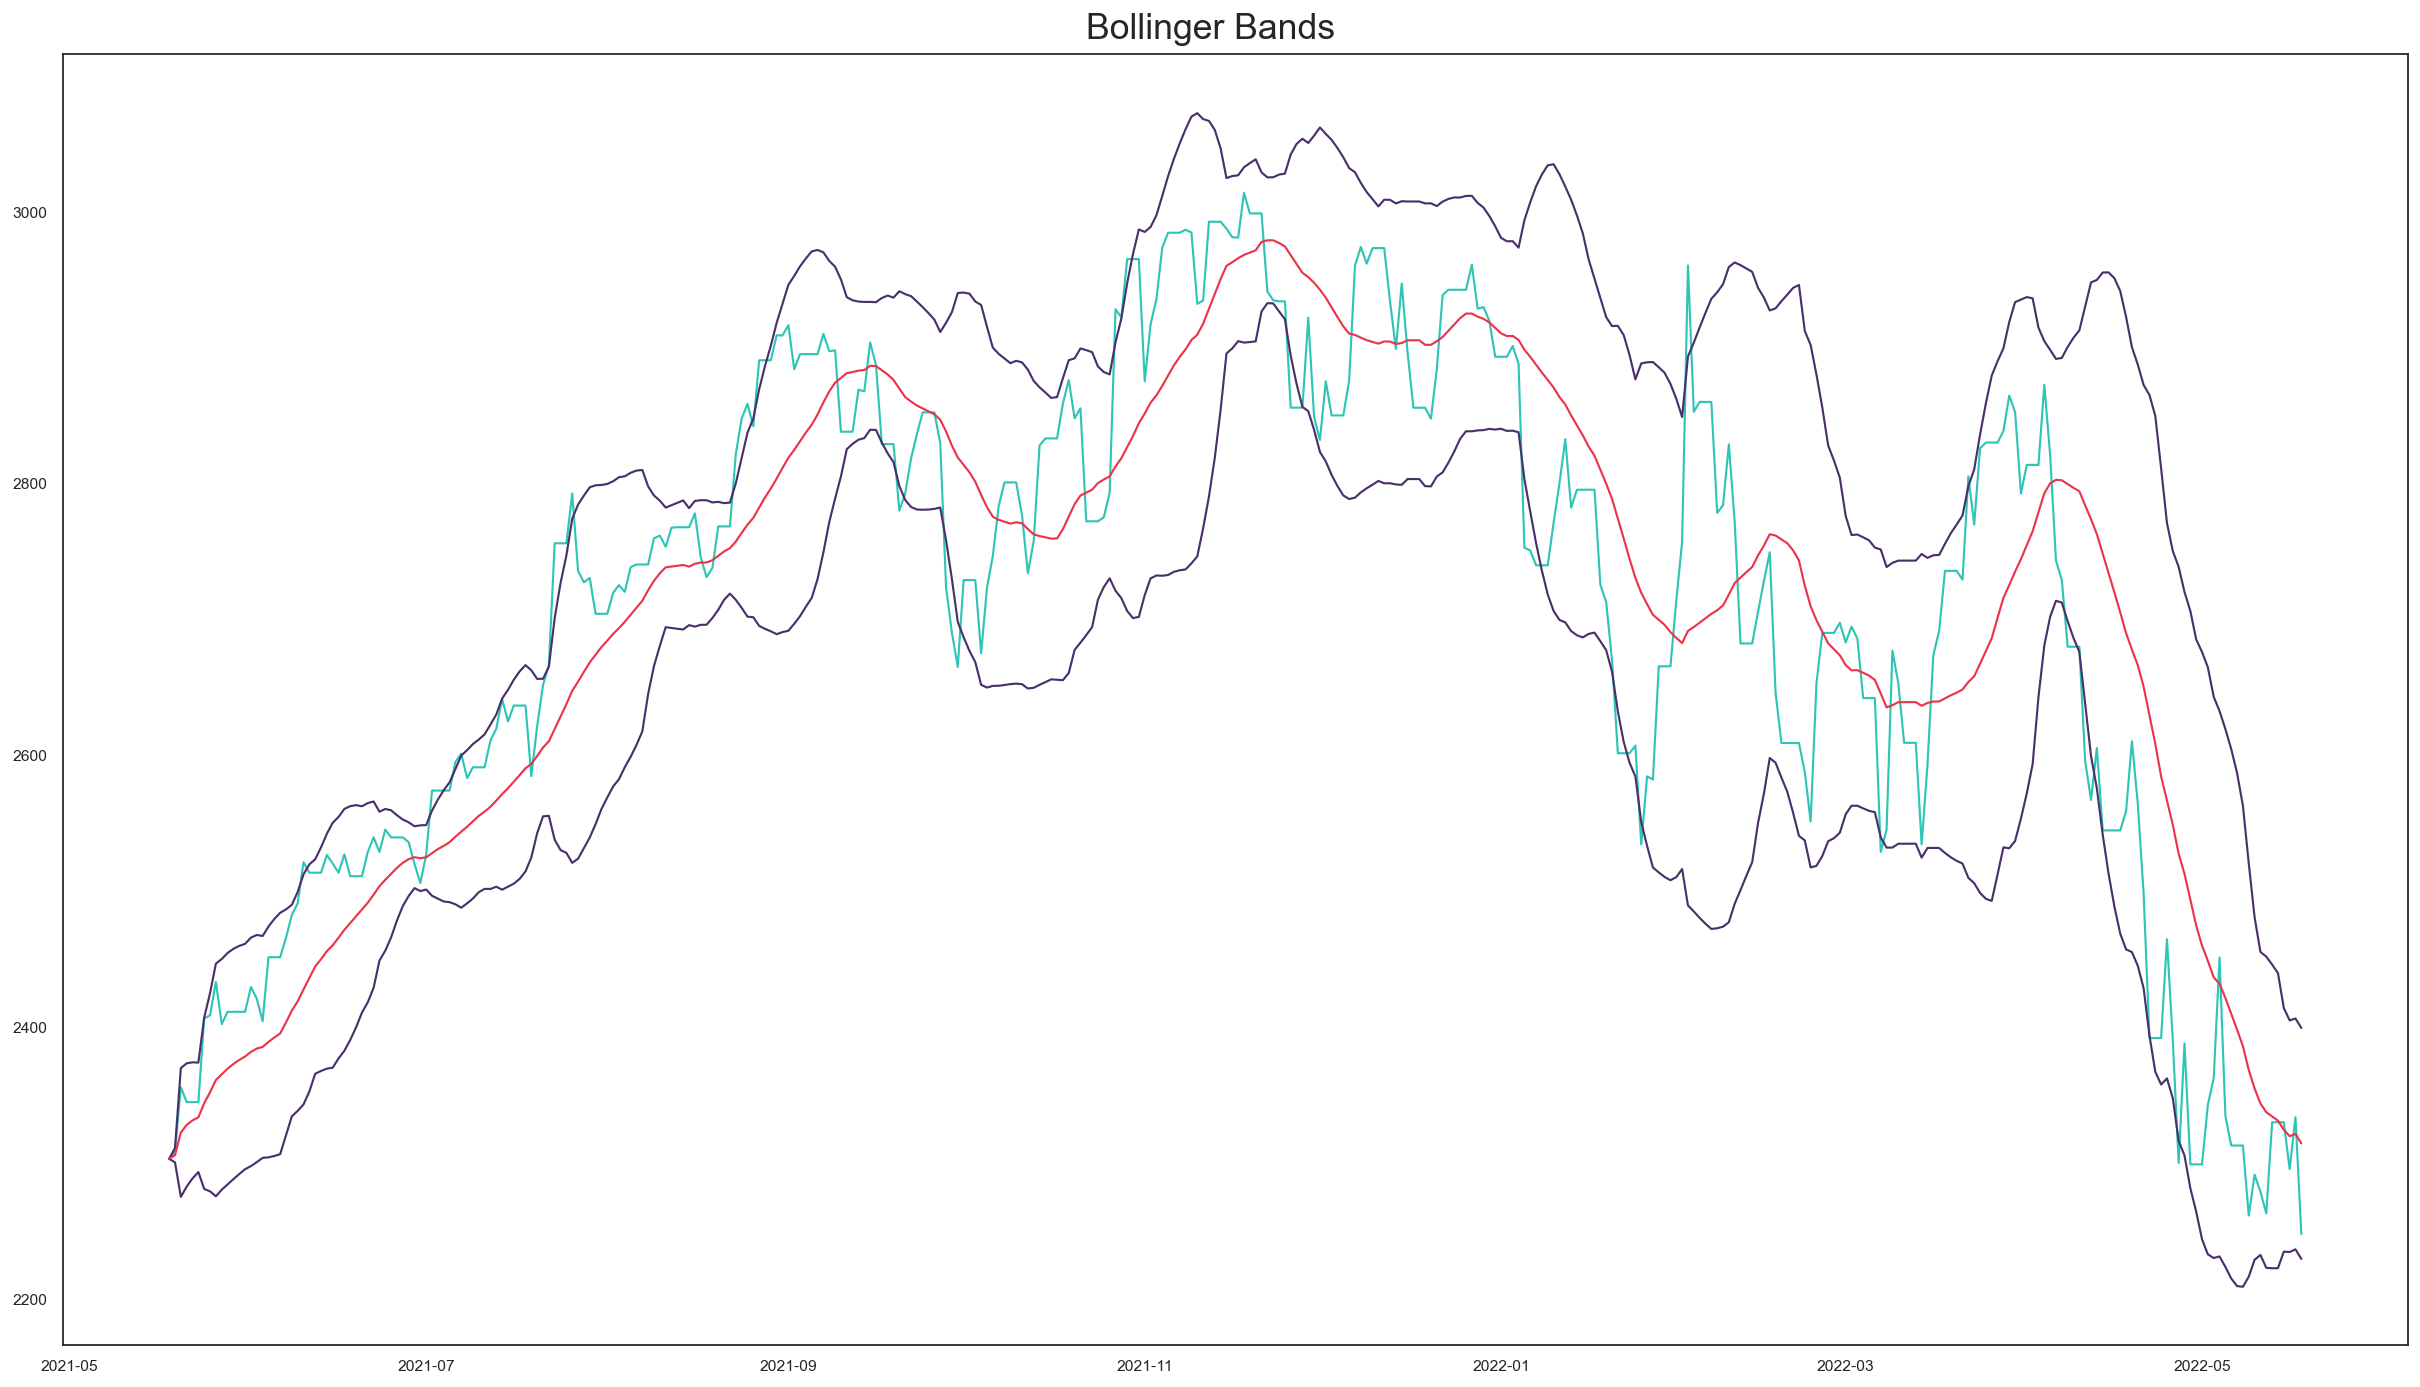

In [72]:
## Plot bollinger bands
fig, ax = plt.subplots(figsize=(19,11), sharex=True, sharey=False)


#ax = axes.flatten()[dfi]

#ax.set_title(str.upper(plot_prefix), fontsize=16)

ax.plot(fin_data_ta[['Close']], color=CAT_COLORS[0])
ax.plot(fin_data_ta[['volatility_bbh']], label='High BB', color=CAT_COLORS[2])
ax.plot(fin_data_ta[['volatility_bbl']], label='Low BB', color=CAT_COLORS[2])
ax.plot(fin_data_ta[['volatility_bbm']], label='EMA BB', color=CAT_COLORS[-1])
    
    

fig.suptitle('Bollinger Bands', fontsize=20)
plt.tight_layout()
save_fig('Bollinger Bands', fig)

plt.show()

In [81]:
ta_viz_feats = [
    "Open", "High", "Low", "Close", "Volume", 
    'momentum_rsi', 
    'trend_macd_signal', 'trend_macd_diff', 'trend_macd', 
    'volatility_bbh', 'volatility_bbl', 'volatility_bbm', 
    'volatility_atr', 
]

In [82]:
fin_data_ta[ta_viz_feats]

,Open,High,Low,Close,Volume,momentum_rsi,trend_macd_signal,trend_macd_diff,trend_macd,volatility_bbh,volatility_bbl,volatility_bbm,volatility_atr
Date,,,,,,,,,,,,,
2021-05-18,2336.906006,2343.149902,2303.159912,2303.429932,865100.0,100.000000,0.000000,0.000000,0.000000,2303.429932,2303.429932,2303.429932,0.000000
2021-05-19,2264.399902,2316.760010,2263.520020,2308.709961,967500.0,100.000000,0.084240,0.336959,0.421199,2311.349976,2300.789917,2306.069946,0.000000
2021-05-20,2328.040039,2360.340088,2321.090088,2356.090088,1191600.0,100.000000,0.972594,3.553416,4.526009,2370.099411,2275.387242,2322.743327,0.000000
2021-05-21,2365.989990,2369.000000,2342.370117,2345.100098,1141600.0,81.541372,2.140826,4.672930,6.813756,2373.684675,2282.980364,2328.332520,0.000000
2021-05-22,2365.989990,2369.000000,2342.370117,2345.100098,1141600.0,81.541372,3.418361,5.110140,8.528501,2374.410635,2288.961435,2331.686035,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-14,2296.909912,2361.699951,2280.000000,2330.310059,1486000.0,44.392170,-70.272120,11.154061,-59.118059,2440.055334,2222.938660,2331.496997,85.011677
2022-05-15,2296.909912,2361.699951,2280.000000,2330.310059,1486000.0,44.392170,-66.991570,13.122201,-53.869369,2414.423920,2235.101080,2324.762500,84.680504
2022-05-16,2307.679932,2332.149902,2286.699951,2295.850098,1164100.0,41.142975,-63.971695,12.079501,-51.892194,2405.273195,2234.824803,2320.048999,80.757449


## Viz

In [51]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import json


In [ ]:
ax.plot(fin_data_ta[['volatility_bbh']], label='High BB', color=CAT_COLORS[2])
ax.plot(fin_data_ta[['volatility_bbl']], label='Low BB', color=CAT_COLORS[2])
ax.plot(fin_data_ta[['volatility_bbm']], label='EMA BB', color=CAT_COLORS[-1])


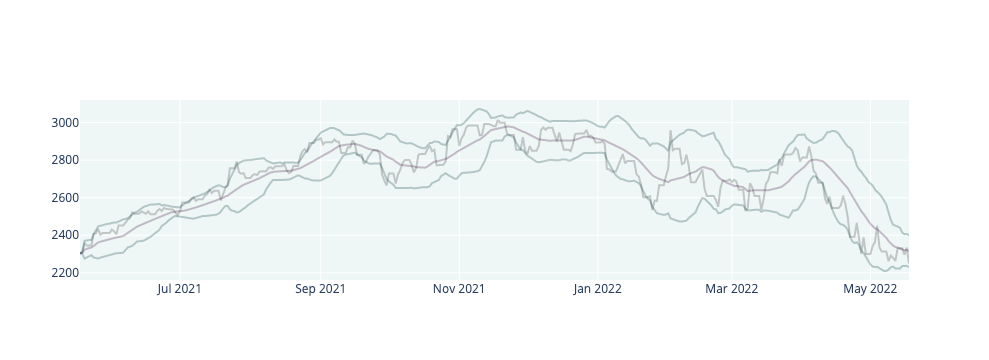

In [73]:
symbol = 'GC=F'
# create graph
title = 'Closing price ' + symbol

gdp_layout = go.Layout(
        height=300,
        #paper_bgcolor=COLORS[1],
        plot_bgcolor='#eef6f6',
        )

fig_gdp = go.Figure(layout=gdp_layout)
fig_gdp.add_trace(go.Scatter(x=fin_data_ta.index, y=fin_data_ta['Close'],
                    mode='lines',
                    opacity=.25,
                    marker=dict(color='#333333')
                    ))

fig_gdp.add_trace(go.Scatter(x=fin_data_ta.index, y=fin_data_ta['volatility_bbh'],
                    mode='lines',
                    opacity=.25,
                    marker=dict(color='#003333')
                    ))

fig_gdp.add_trace(go.Scatter(x=fin_data_ta.index, y=fin_data_ta['volatility_bbl'],
                    mode='lines',
                    opacity=.25,
                    marker=dict(color='#003333')
                    ))
fig_gdp.add_trace(go.Scatter(x=fin_data_ta.index, y=fin_data_ta['volatility_bbm'],
                    mode='lines',
                    opacity=.25,
                    marker=dict(color='#330033')
                    ))


fig_gdp.update_traces(showlegend=False)
    

In [ ]:
ax.plot(df_all_ta[[plot_prefix+'trend_macd_signal']], label='MACD Signal', color=CAT_COLORS[1])
ax.plot(df_all_ta[[plot_prefix+'trend_macd_diff']], label='MACD Difference', color=CAT_COLORS[3])
ax.plot(df_all_ta[[plot_prefix+'trend_macd']], label='MACD', color=CAT_COLORS[-1], linestyle='dashed')


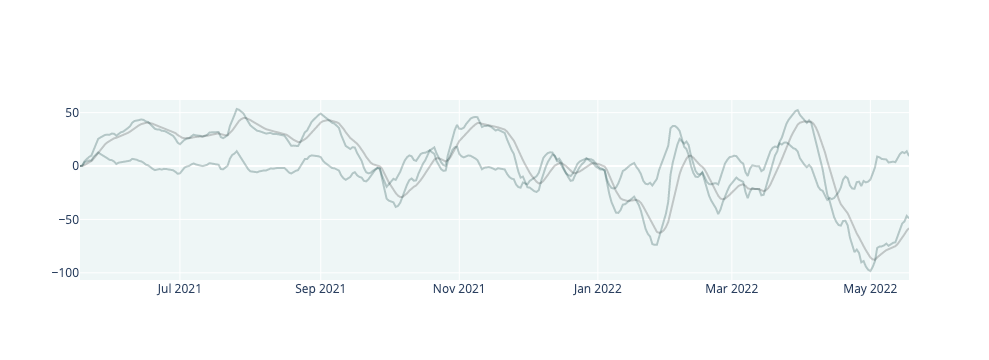

In [88]:
symbol = 'GC=F'
# create graph
title = 'Closing price ' + symbol

gdp_layout = go.Layout(
        height=300,
        #paper_bgcolor=COLORS[1],
        plot_bgcolor='#eef6f6',
        )

fig_gdp = go.Figure(layout=gdp_layout)
fig_gdp.add_trace(go.Scatter(x=fin_data_ta.index, y=fin_data_ta['trend_macd_signal'],
                    mode='lines',
                    opacity=.25,
                    name='trend_macd_signal',
                    marker=dict(color='#333333')
                    ))

fig_gdp.add_trace(go.Scatter(x=fin_data_ta.index, y=fin_data_ta['trend_macd_diff'],
                    mode='lines',
                    opacity=.25,
                    marker=dict(color='#003333')
                    ))

fig_gdp.add_trace(go.Scatter(x=fin_data_ta.index, y=fin_data_ta['trend_macd'],
                    mode='lines',
                    opacity=.25,
                    marker=dict(color='#003333')
                    ))


fig_gdp.update_traces(showlegend=False)
    

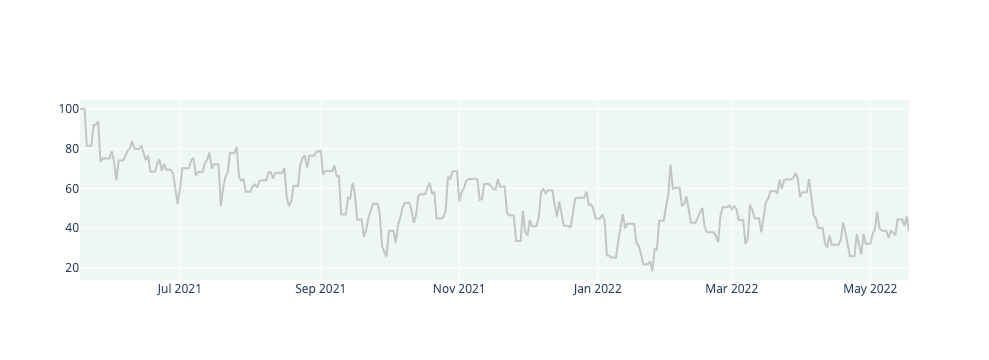

In [77]:
symbol = 'GC=F'
# create graph
title = 'Closing price ' + symbol

gdp_layout = go.Layout(
        height=300,
        #paper_bgcolor=COLORS[1],
        plot_bgcolor='#eef6f6',
        )

fig_gdp = go.Figure(layout=gdp_layout)
fig_gdp.add_trace(go.Scatter(x=fin_data_ta.index, y=fin_data_ta['momentum_rsi'],
                    mode='lines',
                    opacity=.25,
                    marker=dict(color='#333333')
                    ))



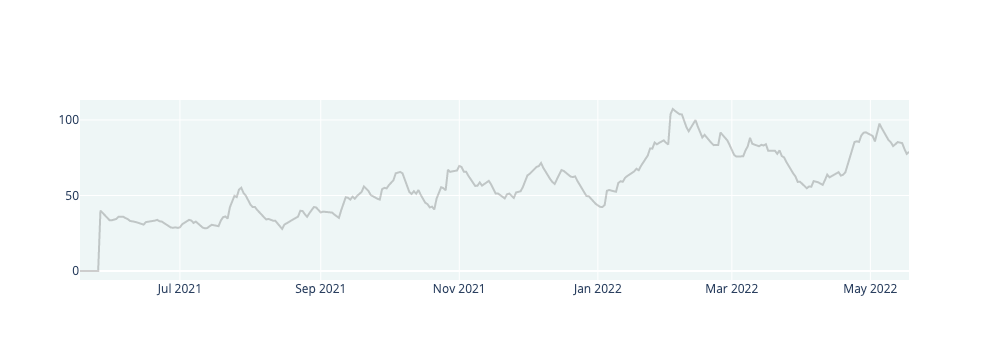

In [78]:
symbol = 'GC=F'
# create graph
title = 'Closing price ' + symbol

gdp_layout = go.Layout(
        height=300,
        #paper_bgcolor=COLORS[1],
        plot_bgcolor='#eef6f6',
        )

fig_gdp = go.Figure(layout=gdp_layout)
fig_gdp.add_trace(go.Scatter(x=fin_data_ta.index, y=fin_data_ta['volatility_atr'],
                    mode='lines',
                    opacity=.25,
                    marker=dict(color='#333333')
                    ))



In [83]:
TESTVARIABLE = "foo"

In [84]:
def test_vars(v):
    TESTVARIABLE = v
    return

In [85]:
test_vars("bar")

In [86]:
print(TESTVARIABLE)

foo
